# Assignemnt 3
## Nakiyah Dhariwala

My Role: 
💰 Case 1: Loan Approval  🟥 Prosecution

## ⚖️ Case 1: Loan Denial Dispute – UCI Adult Income Dataset
#### 🔍 Scenario

Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

#### 🟥 Prosecution
Evaluate whether the model’s decision may have been influenced by inappropriate or unfair reasoning. Explore whether the explanation aligns with what should be expected in a fair credit decision.

#### 🟦 Defense
Justify the decision based on the model’s learned patterns. Consider how well the explanation supports the classification and whether similar profiles are treated consistently.

In [14]:
# 📦 Case 1: Loan Approval Prediction (Adult Income Dataset)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from lime.lime_tabular import LimeTabularExplainer
from alibi.explainers import AnchorTabular

# Load Data
from sklearn.datasets import fetch_openml

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


As a prosecutor, my role is to argue the case that the model's decision was influneced by unfair reasoning when it rejected Jane DOw's application on the basis of her income level. 

Throughout this report, I shall analyze the results and data to 

## Given Code Template

In [15]:
adult = fetch_openml(name="adult", version=2, as_frame=True)
df_raw = adult.frame

### Preprocessing and building Random Forest Model

In [16]:
# Clean and preprocess
df = df_raw.dropna()
df = df.copy()
encoders = {}
label_cols = df.select_dtypes(include="category").columns.tolist()

for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"].apply(lambda x: 1 if x == ">50K" else 0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
# Train simple RF model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9045

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045



### Focus Instance

In [18]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)

jane_encoded = {
    "age": 37,
    "workclass": encoders["workclass"].transform(["Private"])[0],
    "education": encoders["education"].transform(["Bachelors"])[0],
    "marital-status": encoders["marital-status"].transform(["Never-married"])[0],
    "occupation": encoders["occupation"].transform(["Exec-managerial"])[0],
    "relationship": encoders["relationship"].transform(["Not-in-family"])[0],
    "race": encoders["race"].transform(["White"])[0],
    "sex": encoders["sex"].transform(["Female"])[0],
    "hours-per-week": 50,
    "native-country": encoders["native-country"].transform(["United-States"])[0],
    "capital-gain": 0,
    "capital-loss": 0,
    "education-num": 13,
}

jane_df = pd.DataFrame([jane_encoded])
jane_df = jane_df[X_train.columns]
pred = model_adult.predict(jane_df)
print(
    "Prediction for Jane Dow (Loan Eligibility):",
    "Approved" if pred[0] == 1 else "Denied",
)

Prediction for Jane Dow (Loan Eligibility): Denied


From the Random Forest classification report, we can see that there are perfect scores across the board (precision, recall, F1 = 1.00) but only for class 0. 

That essentially means that the model is predicting everyone as ≤50K, with no examples of >50K. In a way, we could say that this model appears perfect, however that would be extremely misleading. Maybe this is why Jane was denied, not because of her qualifications (i.e. features) but the model itself. 

I want to investigate the initial model further but before jumping to conclusions, I will still use LIME and Anchor methods to test whether the model truly uses any meaningful features in jane's case or not.

### LIME #1: Explain Jane's prediction

In [19]:
# LIME needs categorical indices & names
all_cols = X_train.columns.tolist()
cat_cols = [c for c in all_cols if c in encoders]
categorical_features = [all_cols.index(c) for c in cat_cols]
categorical_names = {all_cols.index(c): encoders[c].classes_.tolist() for c in cat_cols}


# Wrapping predict_proba so LIME sees proper column names
def predict_proba_df(x_array):
    x_df = pd.DataFrame(x_array, columns=all_cols)
    return model_adult.predict_proba(x_df)


# Building the explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=all_cols,
    class_names=["<=50K", ">50K"],
    categorical_features=categorical_features,
    categorical_names=categorical_names,
    discretize_continuous=True,
    mode="classification",
    random_state=42,
)

# 5) explaining Jane's case
exp = explainer.explain_instance(
    data_row=jane_df.iloc[0].values,
    predict_fn=predict_proba_df,
    num_features=10,
    top_labels=1,
)

print("LIME (buggy) — feature -> contribution")
for feat, weight in exp.as_list(label=exp.top_labels[0]):
    print(f"{feat}: {weight:+.3f}")

LIME (buggy) — feature -> contribution
28.00 < age <= 37.00: +0.000
workclass=Private: +0.000
education=Bachelors: +0.000
10.00 < education-num <= 13.00: +0.000
marital-status=Never-married: +0.000
occupation=Exec-managerial: +0.000
relationship=Not-in-family: +0.000
race=White: +0.000
sex=Female: +0.000
capital-gain <= 0.00: +0.000


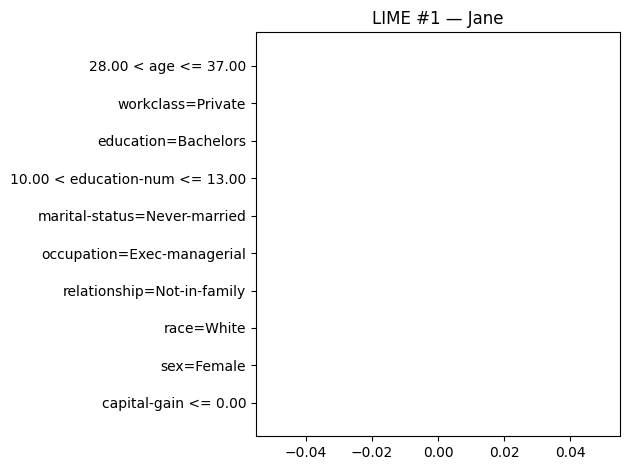

In [20]:
fig = exp.as_pyplot_figure(label=exp.top_labels[0])
plt.title("LIME #1 — Jane")
plt.tight_layout()
plt.show()

### Anchor #1: rule-style explanation

In [21]:
# predictor wrapper that returns class labels
def predict_labels_df(x_array):
    x_df = pd.DataFrame(x_array, columns=all_cols)
    return model_adult.predict(x_df)


# 3) creating & fitting the explainer
anchor_exp = AnchorTabular(
    predictor=predict_labels_df,
    feature_names=all_cols,
    categorical_names=categorical_names,
)
anchor_exp.fit(X_train.values, disc_perc=[25, 50, 75])

# 4) explaining Jane
anchor = anchor_exp.explain(jane_df.iloc[0].values, threshold=0.95)

print("ANCHOR (buggy) — rule:", anchor.anchor)
print("Precision:", anchor.precision)
print("Coverage:", anchor.coverage)

ANCHOR (buggy) — rule: []
Precision: [1.]
Coverage: 1


My analysis from LIME and Anchor:

In the LIME output, we can see that every feature has a contribution of +0.000 which simply means that LIME can't identify any feature influencing Jane's denial. 


In addition, Anchor could also not find a condition (i.e. []) to explain Jane's outcome. Precision and COverage of 1 essentially indicate that anyone and everyone is 'always' denied. 

Thus, both LIME and Anchor fail to produce meaningful explanations which is concerning because if two independent XAI models fail to produce meaningful reasoning, it wouldn't matter if Jane was educated, worked higher hours per week, etc. - the model will always deny her.

As we saw from the classification report above, precision, recall and f1 all resulted in a 1 for class 0, it further reinforces my belief that the issue lies not with Jane’s profile but with the data, preprocessing, or the model itself. My next step would be to go back to EDA. 